In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
N = 5

G = nx.complete_graph(N)

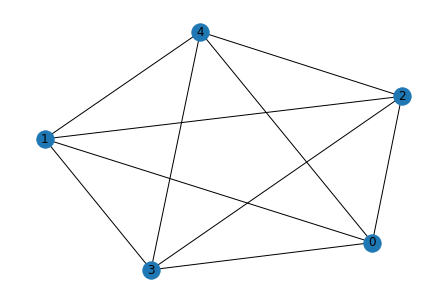

In [3]:
nx.draw(G, with_labels=True)    
plt.show()

nx.write_adjlist(G, "CO.adjlist")

In [4]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)] 
    for c in b : 
        A[a][c] = 1

In [5]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

In [6]:
matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)

diff = [np.abs(autovaloriP[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP[i] - 1) == minDiff:
        pS = autovettoriP[i]
        print("Eigenvector found")
        break

if pS[0] < 0:
    pS = -pS

Eigenvector found


In [7]:
autovaloriP

array([-0.25,  1.  , -0.25, -0.25, -0.25])

In [8]:
matrixL = np.identity(N) - matrixP

In [9]:
autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)

diff = [np.abs(autovaloriL[i]) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriL[i]) == minDiff:
        pS_L = autovettoriL[i]
        print("Eigenvector found")
        break

if pS_L[0] < 0:
    pS_L = -pS_L

Eigenvector found


In [10]:
autovaloriL

array([1.25, 0.  , 1.25, 1.25, 1.25])

In [11]:
i = 13
np.round(pS, i) == np.round(pS_L, i)

array([ True,  True,  True,  True,  True])

In [12]:
np.round(1-max(autovaloriP[1:]), i) == np.round(min(autovaloriL[1:]), i)

True

In [13]:
pS = np.round(pS.real, i)
print(pS)

[0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


In [14]:
np.savetxt("CO-pS.txt", pS, delimiter='\n')